Training Improved DQN Agent
Episode 100/1000, Mean Reward: 423.55, Epsilon: 0.835
Episode 200/1000, Mean Reward: 445.27, Epsilon: 0.670
Episode 300/1000, Mean Reward: 463.32, Epsilon: 0.505
Episode 400/1000, Mean Reward: 466.80, Epsilon: 0.340
Episode 500/1000, Mean Reward: 495.54, Epsilon: 0.175
Episode 600/1000, Mean Reward: 510.05, Epsilon: 0.010
Episode 700/1000, Mean Reward: 493.88, Epsilon: 0.010
Episode 800/1000, Mean Reward: 496.40, Epsilon: 0.010
Episode 900/1000, Mean Reward: 514.55, Epsilon: 0.010
Episode 1000/1000, Mean Reward: 503.28, Epsilon: 0.010


Evaluating Baselines

Improved DQN Hit Rate: 57.15%
LRU Hit Rate: 61.25%
FIFO Hit Rate: 57.15%
LFU Hit Rate: 52.85%


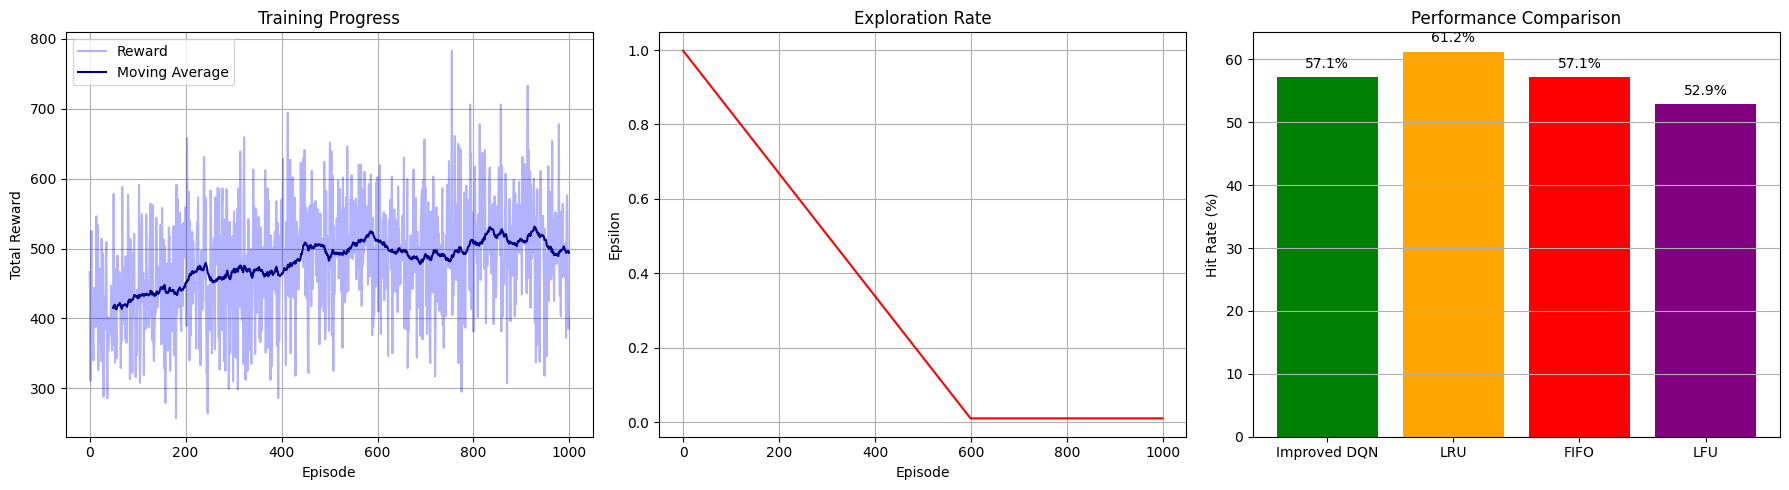

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, OrderedDict, defaultdict
import matplotlib.pyplot as plt


class CacheEnv(gym.Env):
    
    def __init__(self, cache_size=8, memory_size=64, sequence_length=100):
        super(CacheEnv, self).__init__()
        self.cache_size = cache_size
        self.memory_size = memory_size
        self.sequence_length = sequence_length
        self.cache = OrderedDict()
        self.access_sequence = []
        self.current_step = 0
        self.action_space = spaces.Discrete(cache_size)
        self.observation_space = spaces.Box(low=-1, high=memory_size, 
                                           shape=(cache_size * 5 + 4,), dtype=np.float32)
        self.hits = 0
        self.misses = 0
        self.total_accesses = 0
        self.access_freq = defaultdict(int)
        self.last_access_time = {}
        self.access_history = deque(maxlen=20)

    def _generate_access_pattern(self, pattern_type='mixed'):
        if pattern_type == 'sequential':
            return [i % self.memory_size for i in range(self.sequence_length)]
        elif pattern_type == 'loop':
            loop_size = min(10, self.memory_size)
            return [i % loop_size for i in range(self.sequence_length)]
        elif pattern_type == 'random':
            return [random.randint(0, self.memory_size - 1) for _ in range(self.sequence_length)]
        elif pattern_type == 'mixed':
            seq = []
            hot_set = list(range(6))
            warm_set = list(range(6, 12))
            cold_set = list(range(12, self.memory_size))
            for _ in range(self.sequence_length):
                r = random.random()
                if r < 0.6:
                    seq.append(random.choice(hot_set))
                elif r < 0.85:
                    seq.append(random.choice(warm_set))
                else:
                    seq.append(random.choice(cold_set))
            return seq
        elif pattern_type == 'realistic':
            seq = []
            hot_set = list(range(8))
            warm_set = list(range(8, 16))
            cold_set = list(range(16, self.memory_size))
            phase_length = self.sequence_length // 4
            
            for phase in range(4):
                phase_hot = random.sample(hot_set + warm_set, 6)
                for _ in range(phase_length):
                    r = random.random()
                    if r < 0.7:
                        seq.append(random.choice(phase_hot))
                    elif r < 0.9:
                        seq.append(random.choice(warm_set))
                    else:
                        seq.append(random.choice(cold_set))
            return seq

    def _get_state(self):
        cache_contents = list(self.cache.keys()) if self.cache else []
        cache_contents += [-1] * (self.cache_size - len(cache_contents))
        
        frequencies = []
        recencies = []
        future_refs = []
        
        for addr in cache_contents:
            if addr == -1:
                frequencies.append(0)
                recencies.append(0)
                future_refs.append(0)
            else:
                frequencies.append(self.access_freq.get(addr, 0))
                recencies.append(self.current_step - self.last_access_time.get(addr, 0))
                
                future_count = 0
                for i in range(self.current_step + 1, min(self.current_step + 20, len(self.access_sequence))):
                    if self.access_sequence[i] == addr:
                        future_count += 1
                future_refs.append(future_count)
        
        next_addr = self.access_sequence[self.current_step] if self.current_step < len(self.access_sequence) else -1
        future_addrs = []
        for i in range(1, min(4, len(self.access_sequence) - self.current_step)):
            future_addrs.append(self.access_sequence[self.current_step + i])
        while len(future_addrs) < 3:
            future_addrs.append(-1)
        
        next_in_cache = []
        for addr in cache_contents:
            if addr == -1:
                next_in_cache.append(0)
            else:
                next_in_cache.append(1 if addr == next_addr else 0)
        
        state = (cache_contents + frequencies + recencies + 
                future_refs + next_in_cache + [next_addr] + future_addrs)
        return np.array(state, dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        pattern = options.get('pattern', 'realistic') if options else 'realistic'
        self.access_sequence = self._generate_access_pattern(pattern)
        self.cache = OrderedDict()
        self.current_step = 0
        self.hits = 0
        self.misses = 0
        self.total_accesses = 0
        self.access_freq = defaultdict(int)
        self.last_access_time = {}
        self.access_history.clear()
        return self._get_state(), {}

    def step(self, action):
        if self.current_step >= len(self.access_sequence):
            return self._get_state(), 0, True, False, {}
        
        addr = self.access_sequence[self.current_step]
        self.access_freq[addr] += 1
        self.last_access_time[addr] = self.current_step
        self.access_history.append(addr)
        
        reward = 0
        if addr in self.cache:
            self.hits += 1
            reward = 10
            self.cache.move_to_end(addr)
        else:
            self.misses += 1
            reward = -1
            
            if len(self.cache) >= self.cache_size:
                cache_list = list(self.cache.keys())
                if action < len(cache_list):
                    evicted_addr = cache_list[action]
                    
                    future_uses = 0
                    for i in range(self.current_step + 1, min(self.current_step + 20, len(self.access_sequence))):
                        if self.access_sequence[i] == evicted_addr:
                            future_uses += 1
                    
                    if future_uses > 0:
                        reward -= (future_uses * 2)
                    
                    del self.cache[evicted_addr]
                else:
                    self.cache.popitem(last=False)
            
            self.cache[addr] = 1
        
        self.total_accesses += 1
        self.current_step += 1
        done = self.current_step >= len(self.access_sequence)
        return self._get_state(), reward, done, False, {}

    def render(self):
        hit_rate = self.hits / max(1, self.total_accesses) * 100
        print(f"Step: {self.current_step}/{len(self.access_sequence)}")
        print(f"Cache: {list(self.cache.keys())}")
        print(f"Hits: {self.hits}, Misses: {self.misses}, Hit Rate: {hit_rate:.2f}%")


class LRUPolicy:
    def __init__(self, cache_size):
        self.cache = OrderedDict()
        self.cache_size = cache_size

    def access(self, addr):
        if addr in self.cache:
            self.cache.move_to_end(addr)
            return True
        else:
            if len(self.cache) >= self.cache_size:
                self.cache.popitem(last=False)
            self.cache[addr] = 1
            return False

    def reset(self):
        self.cache = OrderedDict()


class FIFOPolicy:
    def __init__(self, cache_size):
        self.cache = OrderedDict()
        self.cache_size = cache_size

    def access(self, addr):
        if addr in self.cache:
            return True
        else:
            if len(self.cache) >= self.cache_size:
                self.cache.popitem(last=False)
            self.cache[addr] = 1
            return False

    def reset(self):
        self.cache = OrderedDict()


class LFUPolicy:
    def __init__(self, cache_size):
        self.cache = {}
        self.freq = {}
        self.cache_size = cache_size

    def access(self, addr):
        if addr in self.cache:
            self.freq[addr] += 1
            return True
        else:
            if len(self.cache) >= self.cache_size:
                min_freq_addr = min(self.freq, key=self.freq.get)
                del self.cache[min_freq_addr]
                del self.freq[min_freq_addr]
            self.cache[addr] = 1
            self.freq[addr] = 1
            return False

    def reset(self):
        self.cache = {}
        self.freq = {}


class DuelingDQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(DuelingDQNetwork, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        features = self.feature(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return qvals


class PrioritizedReplayMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = []
        self.priorities = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.priorities else 1.0
        
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.memory[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
        
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.memory), batch_size, p=probs, replace=False)
        samples = [self.memory[idx] for idx in indices]
        
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        
        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority + 1e-6

    def __len__(self):
        return len(self.memory)


class ImprovedDQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.0003, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_steps=60000,
                 replay_memory_size=50000, batch_size=128, target_update_freq=500):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        self.q_network = DuelingDQNetwork(state_dim, action_dim, hidden_dim=256).to(self.device)
        self.target_network = DuelingDQNetwork(state_dim, action_dim, hidden_dim=256).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.replay_memory = PrioritizedReplayMemory(replay_memory_size)
        self.steps = 0
        self.beta_start = 0.4
        self.beta_frames = 100000

    def select_action(self, state, evaluation=False):
        if evaluation or random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()
        else:
            return random.randrange(self.action_dim)

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_memory.push(state, action, reward, next_state, done)

    def update_epsilon(self):
        self.steps += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                       max(0, (self.epsilon_decay_steps - self.steps) / self.epsilon_decay_steps)

    def optimize_model(self):
        if len(self.replay_memory) < self.batch_size:
            return None
        
        beta = min(1.0, self.beta_start + self.steps * (1.0 - self.beta_start) / self.beta_frames)
        transitions, indices, weights = self.replay_memory.sample(self.batch_size, beta)
        
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
        
        batch_state = torch.FloatTensor(np.array(batch_state)).to(self.device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(self.device)
        batch_next_state = torch.FloatTensor(np.array(batch_next_state)).to(self.device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(self.device)
        weights = torch.FloatTensor(weights).unsqueeze(1).to(self.device)
        
        current_q_values = self.q_network(batch_state).gather(1, batch_action)
        
        with torch.no_grad():
            next_actions = self.q_network(batch_next_state).argmax(1).unsqueeze(1)
            next_q_values = self.target_network(batch_next_state).gather(1, next_actions)
            target_q_values = batch_reward + (1 - batch_done) * self.gamma * next_q_values
        
        td_errors = torch.abs(current_q_values - target_q_values).detach().cpu().numpy()
        self.replay_memory.update_priorities(indices, td_errors.flatten())
        
        loss = (weights * nn.MSELoss(reduction='none')(current_q_values, target_q_values)).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
        self.optimizer.step()
        
        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, filepath):
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'steps': self.steps,
            'epsilon': self.epsilon
        }, filepath)

    def load(self, filepath):
        checkpoint = torch.load(filepath)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.steps = checkpoint['steps']
        self.epsilon = checkpoint['epsilon']


def train_agent(env, agent, num_episodes=1000, max_steps=100):
    episode_rewards = []
    epsilon_history = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.store_transition(state, action, reward, next_state, done)
            
            loss = agent.optimize_model()
            agent.update_epsilon()
            
            if agent.steps % agent.target_update_freq == 0:
                agent.update_target_network()
            
            state = next_state
            episode_reward += reward
            
            if done or truncated:
                break
        
        episode_rewards.append(episode_reward)
        epsilon_history.append(agent.epsilon)
        
        if (episode + 1) % 100 == 0:
            mean_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}, Mean Reward: {mean_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    return episode_rewards, epsilon_history


def evaluate_agent(env, agent, num_episodes=10):
    eval_rewards = []
    hit_rates = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        step_count = 0
        
        while not done and step_count < 100:
            action = agent.select_action(state, evaluation=True)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
            step_count += 1
            if truncated:
                break
        
        hit_rate = env.hits / max(1, env.total_accesses) * 100
        eval_rewards.append(episode_reward)
        hit_rates.append(hit_rate)
    
    return eval_rewards, hit_rates


def evaluate_baseline(env, policy, num_episodes=10):
    rewards = []
    hit_rates = []
    
    for episode in range(num_episodes):
        policy.reset()
        env.reset()
        total_reward = 0
        hits = 0
        total = 0
        
        for addr in env.access_sequence:
            is_hit = policy.access(addr)
            if is_hit:
                hits += 1
                total_reward += 10
            else:
                total_reward -= 1
            total += 1
        
        hit_rate = hits / max(1, total) * 100
        rewards.append(total_reward)
        hit_rates.append(hit_rate)
    
    return rewards, hit_rates


def train_cache_comparison(num_episodes=1000):
    env = CacheEnv(cache_size=8, memory_size=64, sequence_length=100)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    print("Training Improved DQN Agent")
    agent = ImprovedDQNAgent(state_dim, action_dim, learning_rate=0.0003, gamma=0.99,
                            epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_steps=60000,
                            replay_memory_size=50000, batch_size=128, target_update_freq=500)
    
    rewards, epsilon = train_agent(env, agent, num_episodes, max_steps=100)
    agent.save('cache_improved.pth')
    
    eval_rewards, eval_hits = evaluate_agent(env, agent, num_episodes=20)
    
    print("\n\nEvaluating Baselines")
    lru_policy = LRUPolicy(cache_size=8)
    lru_eval, lru_hits = evaluate_baseline(env, lru_policy, num_episodes=20)
    
    fifo_policy = FIFOPolicy(cache_size=8)
    fifo_eval, fifo_hits = evaluate_baseline(env, fifo_policy, num_episodes=20)
    
    lfu_policy = LFUPolicy(cache_size=8)
    lfu_eval, lfu_hits = evaluate_baseline(env, lfu_policy, num_episodes=20)
    
    print(f"\nImproved DQN Hit Rate: {np.mean(eval_hits):.2f}%")
    print(f"LRU Hit Rate: {np.mean(lru_hits):.2f}%")
    print(f"FIFO Hit Rate: {np.mean(fifo_hits):.2f}%")
    print(f"LFU Hit Rate: {np.mean(lfu_hits):.2f}%")
    
    return rewards, epsilon, eval_rewards, eval_hits, lru_eval, lru_hits, fifo_eval, fifo_hits, lfu_eval, lfu_hits


def plot_results(rewards, epsilon, eval_rewards, eval_hits, lru_eval, lru_hits, fifo_eval, fifo_hits, lfu_eval, lfu_hits):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(rewards, alpha=0.3, label='Reward', color='blue')
    window = 50
    if window > 0:
        ma = np.convolve(rewards, np.ones(window) / window, mode='valid')
        axes[0].plot(np.arange(len(ma)) + window - 1, ma, label='Moving Average', color='darkblue')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title('Training Progress')
    axes[0].grid(True)
    axes[0].legend()
    
    axes[1].plot(epsilon, color='red')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Epsilon')
    axes[1].set_title('Exploration Rate')
    axes[1].grid(True)
    
    bars = ['Improved DQN', 'LRU', 'FIFO', 'LFU']
    hit_rates = [np.mean(eval_hits), np.mean(lru_hits), np.mean(fifo_hits), np.mean(lfu_hits)]
    
    colors = ['green', 'orange', 'red', 'purple']
    axes[2].bar(bars, hit_rates, color=colors)
    axes[2].set_ylabel('Hit Rate (%)')
    axes[2].set_title('Performance Comparison')
    axes[2].grid(True, axis='y')
    
    for i, v in enumerate(hit_rates):
        axes[2].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('cache_results.png', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    results = train_cache_comparison(num_episodes=1000)
    plot_results(*results)
    
    
    
#rl to decide which algorithm to use
#improve rate either by further developing current methods or by maybe using multiple RL methods/algorithms.
#check performance on different kind or types of tasks: Easy(70-85%), Medium (40-50%), Hard (0-30%)
